In [ ]:
# evo_visualizer.py
import sys
# sys.path.insert(0, '/path/to/nsga-net')
sys.path.insert(0, '/Users/zhichao.lu/Dropbox/2019/github/nsga-net')

from graphviz import Digraph

In [ ]:
import torch
import torch.nn as nn
from copy import copy
from abc import ABC, abstractmethod
from collections import OrderedDict

In [ ]:
class Identity(nn.Module):
    """
    Adding an identity allows us to keep things general in certain places.
    """

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return 

In [ ]:
class PreactResidualNode(nn.Module):
    """
    Basic computation unit.
    Does batchnorm, relu, and convolution (in this order).
    """

    def __init__(self, in_channels, out_channels, stride=1,
                 kernel_size=3, padding=1, bias=False):
        """
        Constructor.
        Default arguments preserve dimensionality of input.
        :param in_channels: input to the node.
        :param out_channels: output channels from the node.
        :param stride: stride of convolution, default 1.
        :param kernel_size: size of convolution kernel, default 3.
        :param padding: amount of zero padding, default 1.
        :param bias: true to use bias, false to not.
        """
        super(PreactResidualNode, self).__init__()

        self.model = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        )

    def forward(self, x):
        """
        Apply forward propagation operation.
        :param x: Variable, input.
        :return: Variable.
        """
        return self.model(x)


In [ ]:
class ResidualPhase(nn.Module):
    """
    Residual Genome phase.
    """

    def __init__(self, gene, in_channels, out_channels, idx, preact=False):
        """
        Constructor.
        :param gene: list, element of genome describing connections in this phase.
        :param in_channels: int, number of input channels.
        :param out_channels: int, number of output channels.
        :param idx: int, index in the network.
        :param preact: should we use the preactivation scheme?
        """
        super(ResidualPhase, self).__init__()

        self.channel_flag = in_channels != out_channels  # Flag to tell us if we need to increase channel size.
        self.first_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1 if idx != 0 else 3, stride=1, bias=False)
        self.dependency_graph = ResidualPhase.build_dependency_graph(gene)

        if preact:
            node_constructor = PreactResidualNode

        else:
            node_constructor = ResidualNode

        nodes = []
        for i in range(len(gene)):
            if len(self.dependency_graph[i + 1]) > 0:
                nodes.append(node_constructor(out_channels, out_channels))
            else:
                nodes.append(None)  # Module list will ignore NoneType.

        self.nodes = nn.ModuleList(nodes)

        #
        # At this point, we know which nodes will be receiving input from where.
        # So, we build the 1x1 convolutions that will deal with the depth-wise concatenations.
        #
        conv1x1s = [Identity()] + [Identity() for _ in range(max(self.dependency_graph.keys()))]
        for node_idx, dependencies in self.dependency_graph.items():
            if len(dependencies) > 1:
                conv1x1s[node_idx] = \
                    nn.Conv2d(len(dependencies) * out_channels, out_channels, kernel_size=1, bias=False)

        self.processors = nn.ModuleList(conv1x1s)
        self.out = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    @staticmethod
    def build_dependency_graph(gene):
        """
        Build a graph describing the connections of a phase.
        "Repairs" made are as follows:
            - If a node has no input, but gives output, connect it to the input node (index 0 in outputs).
            - If a node has input, but no output, connect it to the output node (value returned from forward method).
        :param gene: gene describing the phase connections.
        :return: dict
        """
        graph = {}
        residual = gene[-1][0] == 1

        # First pass, build the graph without repairs.
        graph[1] = []
        for i in range(len(gene) - 1):
            graph[i + 2] = [j + 1 for j in range(len(gene[i])) if gene[i][j] == 1]

        graph[len(gene) + 1] = [0] if residual else []

        # Determine which nodes, if any, have no inputs and/or outputs.
        no_inputs = []
        no_outputs = []
        for i in range(1, len(gene) + 1):
            if len(graph[i]) == 0:
                no_inputs.append(i)

            has_output = False
            for j in range(i + 1, len(gene) + 2):
                if i in graph[j]:
                    has_output = True
                    break

            if not has_output:
                no_outputs.append(i)

        for node in no_outputs:
            if node not in no_inputs:
                # No outputs, but has inputs. Connect to output node.
                graph[len(gene) + 1].append(node)

        for node in no_inputs:
            if node not in no_outputs:
                # No inputs, but has outputs. Connect to input node.
                graph[node].append(0)

        return graph

    def forward(self, x):
        if self.channel_flag:
            x = self.first_conv(x)

        outputs = [x]

        for i in range(1, len(self.nodes) + 1):
            if not self.dependency_graph[i]:  # Empty list, no outputs to give.
                outputs.append(None)

            else:
                outputs.append(self.nodes[i - 1](self.process_dependencies(i, outputs)))

        return self.out(self.process_dependencies(len(self.nodes) + 1, outputs))

    def process_dependencies(self, node_idx, outputs):
        """
        Process dependencies with a depth-wise concatenation and
        :param node_idx: int,
        :param outputs: list, current outputs
        :return: Variable
        """
        return self.processors[node_idx](torch.cat([outputs[i] for i in self.dependency_graph[node_idx]], dim=1))


class ResidualNode(nn.Module):
    """
    Basic computation unit.
    Does convolution, batchnorm, and relu (in this order).
    """

    def __init__(self, in_channels, out_channels, stride=1,
                 kernel_size=3, padding=1, bias=False):
        """
        Constructor.
        Default arguments preserve dimensionality of input.
        :param in_channels: input to the node.
        :param out_channels: output channels from the node.
        :param stride: stride of convolution, default 1.
        :param kernel_size: size of convolution kernel, default 3.
        :param padding: amount of zero padding, default 1.
        :param bias: true to use bias, false to not.
        """
        super(ResidualNode, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """
        Apply forward propagation operation.
        :param x: Variable, input.
        :return: Variable.
        """
        return self.model(x)


In [ ]:
def get_graph_function(type):
    """
    Get the appropriate function to build a dependency graph.
    :param type:
    :return: callable
    """
    if type == "residual":
        return ResidualPhase.build_dependency_graph

    raise NotImplementedError("Genome type {} not supported.".format(type))

In [ ]:
def make_dot_phase(phase, rankdir="UD", format="pdf", title=None, filename="genome", type="residual"):
    """
    Visualize a single phase.
    :param genome: list of lists.
    :param phase: int, index of phase to visualize.
    :param rankdir: direction graph is oriented "UD"=Vertical, "LR"=horizontal.
    :param format: output file format, jpg, png, etc.
    :param title: title of graph.
    :param filename: filename of graph.
    :param type: string, what kind of decoder should we use.
    :return: graphviz dot object.
    :return:
    """
    node_color = "lightblue"
    conv1x1_color = "white"
    sum_color = "green4"
    pool_color = "orange"
    phase_background_color = "gray"
    fc_color = "gray"
    node_shape = "circle"
    conv1x1_shape = "doublecircle"

    gene = phase
    graph_function = get_graph_function(type)
    graph = graph_function(gene)

    nodes = [("node_0", ' ')] + [("node_" + str(j + 1), ' ') for j in range(len(gene) + 1)]
    edges = []

    for sink, dependencies in graph.items():
        for source in dependencies:
            edges.append((nodes[source][0], nodes[sink][0]))

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(format=format, filename=filename+'.gv', node_attr=node_attr, graph_attr=dict(size="12,12"))
    dot.attr(rankdir=rankdir)

    if title:
        dot.attr(label=title+"\n\n")
        dot.attr(labelloc='t')

    dot.node(nodes[0][0], nodes[0][1], fillcolor=conv1x1_color, shape=conv1x1_shape)

    with dot.subgraph(name="cluster") as p:
        p.attr(fillcolor=phase_background_color, label='', fontcolor="black", style="filled")

        for i in range(1, len(nodes) - 1):
            if len(graph[i]) != 0:
                p.node(nodes[i][0], nodes[i][1], fillcolor=node_color, shape=node_shape)

    dot.node(nodes[-1][0], nodes[-1][1], fillcolor=sum_color, shape=node_shape)

    # Add edges.
    for edge in edges:
        dot.edge(*edge)

    dot.attr(dpi="300")

    return 

In [ ]:
def make_dot_genome(genome, rankdir="UD", format="pdf", title=None, filename="genome", type="residual"):
    """
    Graphviz representation of network created by genome.
    :param genome: list of lists.
    :param rankdir: direction graph is oriented "UD"=Vertical, "LR"=horizontal.
    :param format: output file format, jpg, png, etc.
    :param title: title of graph.
    :param filename: filename of graph.
    :param type: string, what kind of decoder should we use.
    :return: graphviz dot object.
    """
    node_color = "lightblue"
    conv1x1_color = "white"
    sum_color = "green4"
    pool_color = "orange"
    phase_background_color = "gray"
    fc_color = "gray"

    node_shape = "circle"
    conv1x1_shape = "doublecircle"

    structure = []

    # Build node ids and names to make building graph easier.
    for i, gene in enumerate(genome):
        all_zeros = sum([sum(t) for t in gene[:-1]]) == 0

        if all_zeros:
            continue  # Skip everything is a gene is all zeros.

        prefix = "gene_" + str(i)
        phase = ("cluster_" + str(i + 1), "Phase " + str(i + 1))

        nodes = [(prefix + "_node_0", ' ')] \
            + [(prefix + "_node_" + str(j + 1), ' ') for j in range(len(gene) + 1)]

        pool = (prefix + "_pool", "Pooling")


        edges = []
        graph_function = get_graph_function(type)
        graph = graph_function(gene)

        for sink, dependencies in graph.items():
            for source in dependencies:
                edges.append((nodes[source][0], nodes[sink][0]))

        structure.append(
            {
                "nodes": nodes,
                "edges": edges,
                "pool": pool,
                "phase": phase,
                "all_zeros": all_zeros,
                "graph": graph
            }
        )

    final_pool = structure[-1]["pool"]
    new_pool = (final_pool[0], "Avg. Pooling")
    structure[-1]["pool"] = new_pool

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(format=format, filename=filename+'.gv', node_attr=node_attr, graph_attr=dict(size="12,12"))
    dot.attr(rankdir=rankdir)

    if title:
        dot.attr(label=title+"\n\n")
        dot.attr(labelloc='t')

    dot.node(str("input"), "Input")

    for j, struct in enumerate(structure):
        nodes = struct['nodes']
        edges = struct['edges']
        phase = struct['phase']
        pool = struct['pool']
        graph = struct['graph']
        all_zeros = struct['all_zeros']

        # Add nodes.
        dot.node(nodes[0][0], nodes[0][1], fillcolor=conv1x1_color, shape=conv1x1_shape)

        if j > 0:
            dot.edge(structure[j - 1]['pool'][0], nodes[0][0])

        if not all_zeros:
            with dot.subgraph(name=phase[0]) as p:
                p.attr(fillcolor=phase_background_color, label='', fontcolor="black", style="filled")

                for i in range(1, len(nodes) - 1):
                    if len(graph[i]) != 0:
                        p.node(nodes[i][0], nodes[i][1], fillcolor=node_color, shape=node_shape)

        dot.node(nodes[-1][0], nodes[-1][1], fillcolor=sum_color, shape=node_shape)
        dot.node(*pool, fillcolor=pool_color)

        # Add edges.
        for edge in edges:
            dot.edge(*edge)

        dot.edge(nodes[-1][0], pool[0])

    dot.edge("input", structure[0]['nodes'][0][0])

    dot.node("linear", "Linear", fillcolor=fc_color)
    dot.edge(structure[-1]['pool'][0], "linear")

    # TODO: Add legend (?)

    return dot

In [ ]:
from graphviz import Graph

In [ ]:
import graphviz

In [ ]:
import numpy as np

In [ ]:
def phase_dencode(phase_bit_string):
    n = int(np.sqrt(2 * len(phase_bit_string) - 7/4) - 1/2)
    genome = []
    for i in range(n):
        operator = []
        for j in range(i + 1):
            operator.append(phase_bit_string[int(i * (i + 1) / 2 + j)])
        genome.append(operator)
    genome.append([phase_bit_string[-1]])
    return genome

In [ ]:
Genome = [[1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1], [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0], [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]]

In [ ]:
genotype_name = "NSGANet"

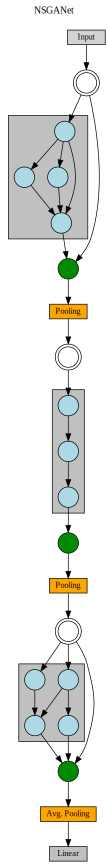

In [ ]:
NSGANet = [[[1], [1, 0], [1, 1, 1], [1]], [[0], [0, 1], [0, 0, 1], [0]], [[1], [0, 0], [1, 0, 1], [1]]]
d = make_dot_genome(NSGANet, title="{}".format(genotype_name), filename="macro_network")
d.view()
with open("/content/macro_network.gv") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)